In [1]:
import numpy as np
from iminuit import Minuit


In [2]:
import matplotlib.pylab as plt
data1 = np.random.normal(loc=20,scale=1, size=1000) # 1st gaussian
data2 = 30*np.random.random(size=1000) # uniform bkg
data3 = np.random.normal(loc=10, scale=10, size=1000) # 2nd gaussian

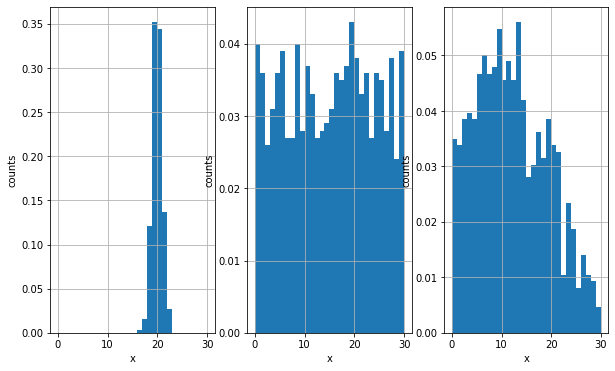

In [3]:
fig, axes = plt.subplots(1,3, figsize=(10,6))
axes[0].grid()
signalPDF, bins, patch = axes[0].hist(data1, bins = 30, range=(0,30), density=True)
axes[0].set_xlabel("x")
axes[0].set_ylabel("counts")

bkgPDF, bins, patch = axes[1].hist(data2, bins = 30, range=(0,30), density=True)
axes[1].grid()
axes[1].set_xlabel("x")
axes[1].set_ylabel("counts")

bkgPDF2, bins, patch = axes[2].hist(data3, bins = 30, range=(0,30), density=True)
axes[2].grid()
axes[2].set_xlabel("x")
axes[2].set_ylabel("counts")

plt.show()
ntotal = 1000
nsig = 0.3 #signal
n1 =  0.4 #First background component.
#third is n2 = 1 - nsig - n1

data = ntotal * (nsig * signalPDF + (1 - nsig) * ( (n1* bkgPDF + (1 - n1)* bkgPDF2)))

[ 25.90245041  24.29236873  23.45269545  25.34277713  26.25269545
  30.52326721  28.63351225  27.16326721  31.29334889  30.87383897
  29.47318553  29.82343057  26.67318553  31.36392065  25.76294049
  20.44196033  23.72212369  29.79253209  59.89220537 133.81269545
 128.05236873  64.06228705  22.59073512  17.36163361  17.92130688
  13.23057176  13.72098016  15.05073512  10.64065344  12.88032672]


Text(0, 0.5, 'density')

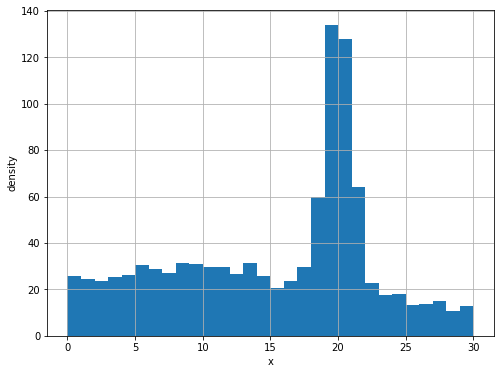

In [4]:
bin_width = np.diff(bins)[0]
bin_centers = bins[:-1] + bin_width/2.

print (data)
fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, data,width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

In [5]:
from pdf.pdf import PdfBase, Model
from pdf.parameter import Parameter

In [10]:
#from pdf.pdf import PdfBase

SignalPDF = PdfBase(signalPDF, name="SignalPDF")
AtmosPDF = PdfBase(bkgPDF, name="AtmosPDF")
CorsikaPDF = PdfBase(bkgPDF2, name="CorsikaPDF")

sigfrac = Parameter(value=0.3, limits=(0,1), fixed=False, name="sigfrac")
sigatmos_frac = Parameter(value=0.1, limits=(0,1), fixed=False, name="atmosfrac")


model = sigfrac * SignalPDF + sigatmos_frac * AtmosPDF

Text(0, 0.5, 'density')

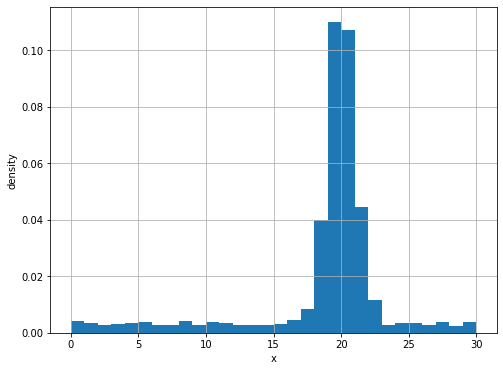

In [18]:

fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, model, width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

In [21]:
def evaluateLLH(pars):
    xi = pars[0]
    modelPDF = xi * signalPDF
    
    modelPDF += (1 - xi) * (pars[1]*bkgPDF + (1 - pars[1])*bkgPDF2)
    
    #Poisson likelihood
    values = data * np.log(modelPDF) - modelPDF        
    return -np.sum(values)

In [ ]:
evaluateLLH([0.2, 0.2])

In [38]:
kwds = dict()
kwds['errordef']=.5
#kwds['print_level']=0

values = [0., 0.]
fix = [False, False]
error = [0.1]
limit = [(-1,1), (-1, 1)]

m = Minuit.from_array_func(evaluateLLH, (0., 1) , limit=limit, name=["nsig", "n1"], **kwds)
m.migrad()

NameError: name 'evaluateLLH' is not defined